In [1]:
# imports
import os
os.sys.path.append(os.path.abspath(".."))

import tensorflow as tf

# import random

# from copy import deepcopy

import pandas as pd
import numpy as np
import h5py

# import keras

from matplotlib import pyplot as plt

# import json

# import notebooks_utils.analysis as utils
from notebooks_utils import visuals

# from IPython.display import display

import project.download_content as content
from project.utils import data
from project.model.loss import BBOX_REF

# METAPATH = os.path.join(content.DATAPATH, 'METADATA')


# from keras.applications import VGG19, VGG16
from keras.preprocessing import image
# from keras.applications.vgg19 import preprocess_input as preprocess_19
# from keras.applications.vgg16 import preprocess_input as preprocess_16
# from keras.models import Model

# from keras import backend as K
# from keras import layers
from keras.optimizers import Adam, SGD

# import swifter

from project.model.ssd_model_300 import ssd_model_300
from project.model.ssd_model_624 import ssd_model_624
from project.model.ssd_model_624_vgg_19 import ssd_model_624_vgg_19
from project.model.loss import SSDloss
# from project.model.iou import iou
# from project.model.smooth_l1 import smooth_l1

# from project.utils import data
datapath = os.path.join(content.DATAPATH, "MODEL", "part_data_300_vgg.h5")

anchors = BBOX_REF.references.values

Using TensorFlow backend.


## loading dataset

In [2]:
with h5py.File(datapath, 'r') as f:
    groups = list(f.keys())

# setting a group to exploration
group = groups[1]

In [3]:
with h5py.File(datapath, 'r') as f:
    images = f[group]['images'][:]
    
images

array([['43d87bf2ef8458e3', 'data/TRAIN/train_4/43d87bf2ef8458e3.jpg'],
       ['43dd9d71505ef57f', 'data/TRAIN/train_4/43dd9d71505ef57f.jpg'],
       ['43ddf01ef4611fc2', 'data/TRAIN/train_4/43ddf01ef4611fc2.jpg'],
       ...,
       ['8b7a92870892a682', 'data/TRAIN/train_8/8b7a92870892a682.jpg'],
       ['8b7b5266d4a88bcb', 'data/TRAIN/train_8/8b7b5266d4a88bcb.jpg'],
       ['8b7d78b15fce30b0', 'data/TRAIN/train_8/8b7d78b15fce30b0.jpg']],
      dtype=object)

anchors: [769]


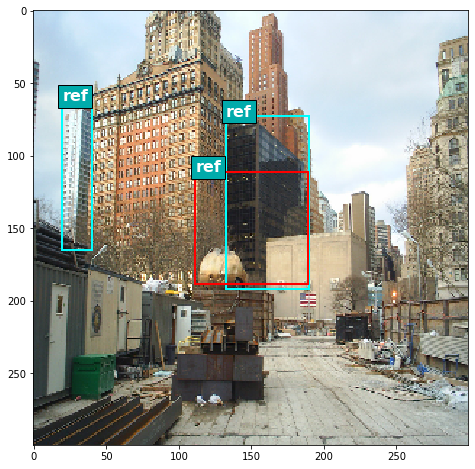

In [4]:
sample = images[2131]

img = image.load_img(sample[1], target_size=(300, 300))

plt.figure(figsize=(12,8))
plt.imshow(img)
# plt.grid()
# plt.xticks(range(0, 301, int(300/75)))
# plt.yticks(range(0, 301, int(300/75)))

with h5py.File(datapath, 'r') as f:
    bboxes = f[group][sample[0]][:][:, [52, 300, 464, -4, -3, -2, -1]]
    
visuals.draw_many_bboxes(img, bboxes[:, -4:], label='ref')

refs = BBOX_REF.match(bboxes[:, -4:])

for ref in refs:
    visuals.draw_bbox(img, anchors[ref], label='ref', color='#ff0000')

print('anchors:', BBOX_REF.match(bboxes[:, -4:]))

In [6]:
bboxes[:, :].shape

(2, 7)

## model

The model has 7 layers to draw the bounding_boxes, they were called as `number_bbs`

in each layer there are some types of bouding boxes, specified as follow:

|         | number of regions | size of filter in pixels | ratios w/h          | number of bounding boxes |
|---------|-------------------|--------------------------|---------------------|--------------------------|
| 1st_bbs | 5776              | 24px/24px                | [1, 1/2, 2]         | 17328                    |
| 2nd_bbs | 1369              | 48px/48px                | [1, 1/2, 2]         | 4107                     |
| 3rd_bbs | 289               | 98px/98px                | [1, 1/2, 1/3, 2, 3] | 1445                     |
| 4th_bbs | 49                | 208px/208px              | [1, 1/2, 1/3, 2, 3] | 245                      |
| 5th_bbs | 25                | 267px/267px              | [1, 1/2, 1/3, 2, 3] | 125                      |
| 6th_bbs | 9                 | 374px/374px              | [1, 1/2, 1/3, 2, 3] | 45                       |
| 7th_bbs | 1                 | 623px/624px              | [1, 1/2, 1/3, 2, 3] | 5                        |

In [7]:
model = ssd_model_300()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 300, 300, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 300, 300, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 150, 150, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

## Training

In [8]:
model.load_weights(content.DATAPATH + '/weights300vgg16.h5')

In [18]:
sample = images[2131]
img = image.load_img(sample[1], target_size=(300, 300))

pred = model.predict(np.expand_dims(image.img_to_array(img), axis=0))[0]

for ind, row in enumerate(pred):
    ref = row[1]
    if ref > .1:
        print(f"{ind:3d}", f": {ref:0.3f} -- ", [f"{r:0.4f}" for r in row[-4:]])

786 : 0.211 --  ['-0.0018', '0.0033', '0.0499', '-0.1410']
787 : 0.109 --  ['-0.0010', '0.0001', '3.4450', '-2.8920']
788 : 0.131 --  ['-0.0012', '0.0058', '-2.8357', '3.2632']
789 : 0.174 --  ['0.0026', '0.0030', '-0.9077', '-0.9859']


anchors: [769]


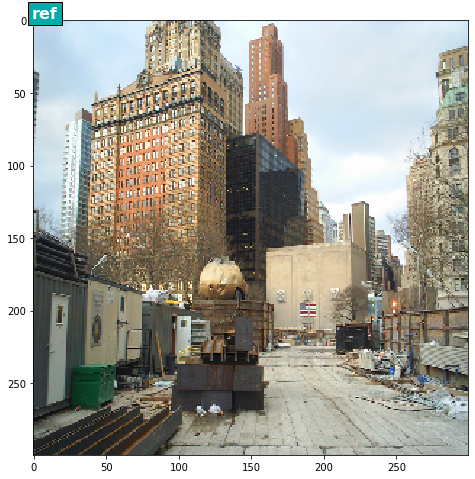

In [14]:
plt.figure(figsize=(12,8))
plt.imshow(img)

with h5py.File(datapath, 'r') as f:
    bboxes = f[group][sample[0]][:][:, [52, 300, 464, -4, -3, -2, -1]]

refs = [789]

for ref in refs:
    visuals.draw_bbox(img, anchors[ref], label='ref', color='#ff0000')

print('anchors:', BBOX_REF.match(bboxes[:, -4:]))

1

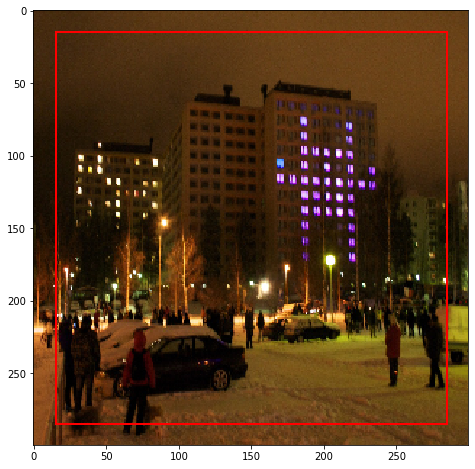

In [14]:
plt.figure(figsize=(12,8))
plt.imshow(img)

tt = 0

bis = []
for i, x in enumerate(pred):
    if i == best_i:
        tt += 1
        b = x
        bi = i
        bis.append(x)
        
        ref = standard_bboxes.references.iloc[bi]
        
        cx = pred[bi][-4]
        cy = pred[bi][-3]
        w = np.exp(pred[bi][-2])
        h = np.exp(pred[bi][-1])
        [cx, cy, w, h]
        
        visuals.draw_bbox(img, ref, color="#ff0000")
tt

1

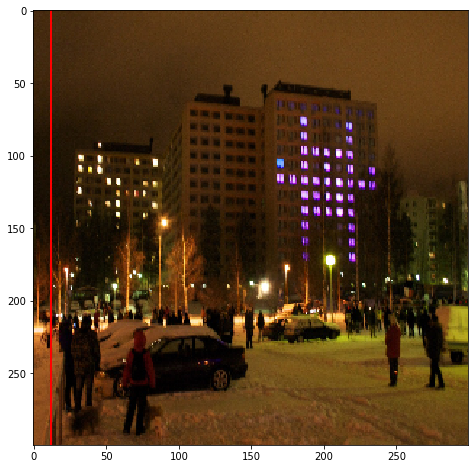

In [18]:
plt.figure(figsize=(12,8))
plt.imshow(img)

tt = 0

bis = []
for i, x in enumerate(pred):
    if i == best_i:
        tt += 1
        b = x
        bi = i
        bis.append(x)
        
        ref = standard_bboxes.references.iloc[bi]
        
        cx = pred[bi][-4]
        cy = pred[bi][-3]
        w = np.exp(pred[bi][-2])
        h = np.exp(pred[bi][-1])
        
        
        visuals.draw_bbox(img, [cx, cy, w, h], color="#ff0000")
tt

In [17]:
h

2.243039